### Setup

In [1]:
import matplotlib.pyplot as plt
import math
import networkx as nx
import numpy as np
import os
import torch
import transformer_lens
import random
import plotly.express as px

from tqdm import tqdm
from transformer_lens import HookedTransformer, HookedTransformerConfig
import transformer_lens.utils as utils

from tree_generation import generate_example, parse_example, GraphDataset
from utils import *
from interp_utils import *

/media/victor/F8D25071D25035DA/Alingment/GraphPlanning/planning-in-transformers/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Model Training

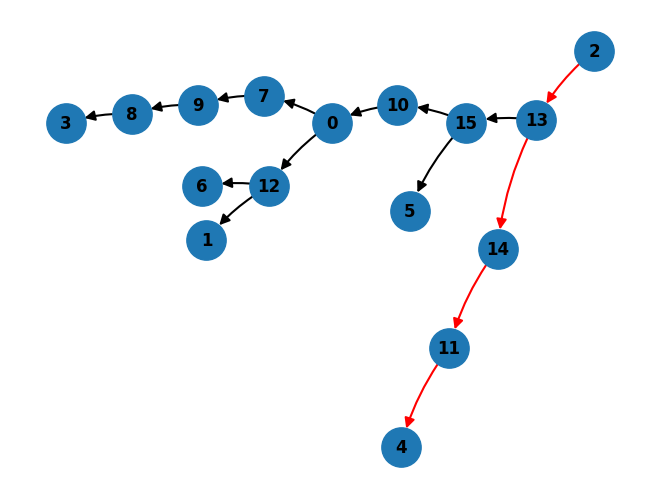

In [2]:
n_examples = 172_000
n_states = 16

dataset = GraphDataset(n_states, "dataset.txt", n_examples)
dataset.visualize_example(0)
train_loader, test_loader = get_loaders(dataset, 32)

In [3]:
cfg = HookedTransformerConfig(
    n_layers=6,
    d_model=128,
    n_ctx=dataset.max_seq_length - 1,
    n_heads=1,
    d_mlp=512,
    d_head=128,
    #attn_only=True,
    d_vocab=len(dataset.idx2tokens),
    device="cuda",
    attention_dir= "causal",
    act_fn="gelu",
)
model = HookedTransformer(cfg)


In [4]:
model_name="model.pt"

In [5]:
# Load in the model if weights are in the directory, else train new model
if os.path.exists(model_name):
    model.load_state_dict(torch.load(model_name))
else:
    train(model, train_loader, test_loader, n_epochs=100, learning_rate=3e-4)
    torch.save(model.state_dict(), model_name)

In [6]:
start_seed = 250_000
num_samples = 100

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 100.0000%
backward: 98.0000%
random: 100.0000%


In [7]:
test_graph = generate_example(n_states, 1231, order="random")
labels, cache = get_example_cache(test_graph, model, dataset)

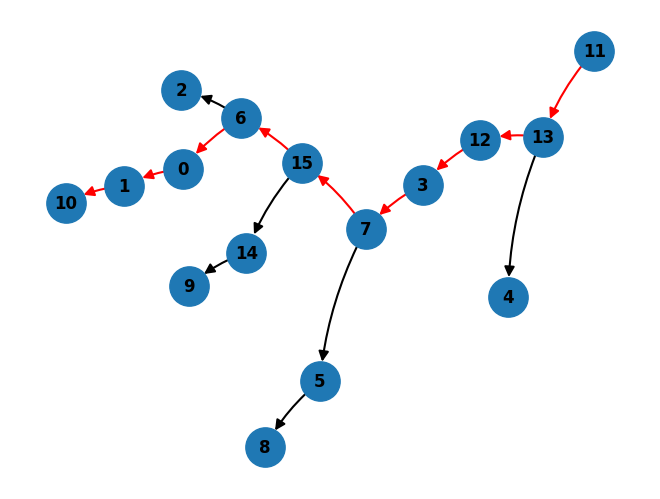

In [8]:
parse_example(test_graph)

In [9]:
def ablation_hook(
            resid_pre,
            hook):
        # Each HookPoint has a name attribute giving the name of the hook.
        resid_pre = resid_pre*0
        return resid_pre

### Useful functions

In [10]:
def logit_lens_hook(pred, model,dataset, lenses=None):
    # Get labels and cache

    labels, _ = get_example_cache(pred, model, dataset)
    tokens = torch.from_numpy(dataset.tokenize(pred)[0:-1]).cuda()
    _, cache = model.run_with_cache(tokens)
    # Calculate end idx of the labels
    end = num_last(labels, ",")
    # Get the logit lens for each layer's resid_post
    outs = []
    for layer in range(1, model.cfg.n_layers+1):
        if layer < model.cfg.n_layers:
            act_name = tl_util.get_act_name("normalized", layer, "ln1")
        else:
            act_name = "ln_final.hook_normalized"
        res_stream = cache[act_name][0]
        if lenses is not None:
            out_proj = res_stream @ lenses[act_name]
        else:
            out_proj = res_stream @ model.W_U
        out_proj = out_proj.argmax(-1)
        lens_out = [dataset.idx2tokens[i] for i in out_proj]
        outs.append([f"Layer {layer} LL"] + lens_out[47:end])
    # Plot data
    header = dict(values=["Current Input"] + labels[47:end])
    rows = dict(values=np.array(outs).T.tolist())
    table = go.Table(header=header, cells=rows)
    layout = go.Layout(width=1000, height=700)
    figure = go.Figure(data=[table], layout=layout)
    figure.show()

In [11]:
def logit_lens_hook_layer(pred, model,dataset,layer, lenses=None,layer_type="ln1"):
    # Get labels and cache

    labels, _ = get_example_cache(pred, model, dataset)
    tokens = torch.from_numpy(dataset.tokenize(pred)[0:-1]).cuda()
    _, cache = model.run_with_cache(tokens)
    # Calculate end idx of the labels
    end = num_last(labels, ",")
    # Get the logit lens for each layer's resid_post
    outs = []
    
    if layer < model.cfg.n_layers:
        act_name = tl_util.get_act_name("normalized", layer, layer_type)
    else:
        act_name = "ln_final.hook_normalized"
    res_stream = cache[act_name][0]
    if lenses is not None:
        out_proj = res_stream @ lenses[act_name]
    else:
        out_proj = res_stream @ model.W_U
        out_proj = out_proj
    # Plot data
    return out_proj


In [12]:
def logit_lens_correct_probs_hook(pred, model, dataset, position, lenses=None):
    # Get labels and cache
    labels, _ = get_example_cache(pred, model, dataset)
    tokens = torch.from_numpy(dataset.tokenize(pred)[0:-1]).cuda()
    _, cache = model.run_with_cache(tokens)
    probs = []
    correct_token = labels[position+1]
    correct_token_idx = dataset.tokens2idx[correct_token]
    for layer in range(1, model.cfg.n_layers+1):
        if layer < model.cfg.n_layers:
            act_name = tl_util.get_act_name("normalized", layer, "ln1")
        else:
            act_name = "ln_final.hook_normalized"
        res_stream = cache[act_name][0]
        if lenses is not None:
            out_proj = res_stream @ lenses[act_name]
        else:
            out_proj = res_stream @ model.W_U
            out_proj = out_proj.softmax(-1)
        probs.append( out_proj[position, correct_token_idx].item() )
    # Plot data
    return probs, correct_token ,labels

### Logit lens experiments 

In [13]:
model.reset_hooks()

In [14]:
model.reset_hooks()
temp_hook_fn = ablation_hook

#model.blocks[5].hook_resid_mid.add_hook(temp_hook_fn)
#model.blocks[4].hook_resid_mid.add_hook(temp_hook_fn)
model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[5].hook_resid_mid.add_hook(temp_hook_fn)
#model.blocks[5].hook_attn_out.add_hook(temp_hook_fn)
#model.blocks[4].hook_attn_out.add_hook(temp_hook_fn)

### Tuned lens

In [15]:
model.reset_hooks()
temp_hook_fn = ablation_hook
model.blocks[4].hook_resid_post.add_hook(temp_hook_fn)

In [16]:
start_seed = 250_000
num_samples = 100

for order in ["forward", "backward", "random"]:
  total_correct = 0
  for seed in range(start_seed, start_seed + num_samples):
      graph = generate_example(16, seed, order=order)
      pred, correct = eval_model(model, dataset, graph)
      if correct:
        total_correct += 1      

  print(f"{order}: {100* total_correct / num_samples:.4f}%")

forward: 0.0000%
backward: 0.0000%
random: 0.0000%


In [17]:
model.reset_hooks()

In [18]:
start_seed = 250_000
num_samples = 100
for i in range(n_states+1):
    X, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=[utils.get_act_name("v", i, "attn") for i in range(0, 6)],
        n_states=n_states,
        n_samples=num_samples,min_path_length=i

    )
    total_correct = 0
    for graph in graphs:
          pred, correct = eval_model(model, dataset, graph)
          if correct:
            total_correct += 1      

    print(f"distance_{i}: {100* total_correct / num_samples:.4f}%")

distance_0: 99.0000%
distance_1: 99.0000%
distance_2: 98.0000%
distance_3: 99.0000%
distance_4: 99.0000%
distance_5: 99.0000%
distance_6: 98.0000%
distance_7: 97.0000%
distance_8: 94.0000%
distance_9: 96.0000%


KeyboardInterrupt: 

In [ ]:
model.reset_hooks()
temp_hook_fn = ablation_hook

model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)

: 

In [ ]:
start_seed = 250_000
num_samples = 100
for i in range(n_states+1):
    X, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=[utils.get_act_name("v", i, "attn") for i in range(0, 6)],
        n_states=n_states,
        n_samples=num_samples,min_path_length=i

    )
    total_correct = 0
    for graph in graphs:
          pred, correct = eval_model(model, dataset, graph)
          if correct:
            total_correct += 1      

    print(f"distance_{i}: {100* total_correct / num_samples:.4f}%")

: 

In [19]:
model.reset_hooks()
temp_hook_fn = ablation_hook
#model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[4].attn.hook_pattern.add_hook(temp_hook_fn)
model.blocks[4].attn.hook_pattern.add_hook(temp_hook_fn)

In [20]:
start_seed = 250_000
num_samples = 100
for i in range(n_states+1):
    X, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=[utils.get_act_name("v", i, "attn") for i in range(0, 6)],
        n_states=n_states,
        n_samples=num_samples,min_path_length=i

    )
    total_correct = 0
    for graph in graphs:
          pred, correct = eval_model(model, dataset, graph)
          if correct:
            total_correct += 1      

    print(f"distance_{i}: {100* total_correct / num_samples:.4f}%")

KeyboardInterrupt: 

# Logit Lens

In [21]:
tokens_ordered=dataset.idx2tokens[:3]+dataset.idx2tokens[9:19] +dataset.idx2tokens[3:9]+dataset.idx2tokens[25:]+dataset.idx2tokens[19:25]


In [22]:
def order_logits(logits):
    logits_ordered=torch.cat([logits[:,:3], logits[:,9:19], logits[:,3:9],logits[:,25:], logits[:,19:25]],1)
    return logits_ordered

In [24]:
model.reset_hooks()
temp_hook_fn = ablation_hook

#model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)


In [25]:
random_graph = generate_example(16, 5, order="random")
random_labels, _ = get_example_cache(random_graph, model, dataset)
random_graph_forwards = generate_example(16, 5, order="forward")
random_labels_forwards, random_graph_forwards_cache = get_example_cache(random_graph_forwards, model, dataset)
random_graph_forwards = generate_example(16, 5, order="random")
random_labels_forwards, _ = get_example_cache(random_graph, model, dataset)

In [26]:
X, graphs = aggregate_activations(
        model=model,
        dataset=dataset,
        activation_keys=[utils.get_act_name("v", i, "attn") for i in range(0, 6)],
        n_states=n_states,
        n_samples=2
        ,min_path_length=15

    )
graph=graphs[0]
labels, _ = get_example_cache(graph, model, dataset)


In [27]:
def generate_goal_distance_examples(distance):
    # Generate clean and corrupted prompts
    clean_prompt = "0>1,1>2,2>3,3>4,4>5,5>6,6>7,7>8,8>9,9>10,10>11,11>12,12>13,13>14,14>15|15:0>1>2>3>4>5>6>7>8>9>10>11>12>13>14>15"
    edges = [f"{i}>{i+1}" for i in range(15 - distance - 1)] + [f"{15 - distance - 1}>{15 - distance}", f"{15 - distance - 1}>{15 - distance + 1}"] + [f"{i}>{i+1}" for i in range(15 - distance + 1, 15)]
    path = '>'.join([str(x) for x in range(16) if x != 15 - distance])
    corrupted_prompt = ",".join(edges) + "|" + f"{15}:{path}"
    return clean_prompt, corrupted_prompt

In [29]:
clean_prompt, corrupted_prompt= generate_goal_distance_examples(5)
graph_forwards=clean_prompt
graph_backwards = '14>15,13>14,12>13,11>12,10>11,9>10,8>9,7>8,6>7,5>6,4>5,3>4,2>3,1>2,0>1|15:0>1>2>3>4>5>6>7>8>9>10>11>12>13>14>15'
labels_forwards, cache_forwards = get_example_cache(graph_forwards, model, dataset)
labels_backwards, cache_backwards = get_example_cache(graph_backwards, model, dataset)
labels_forwards_corrupted, cache_forwards_corrupted_prompt = get_example_cache(corrupted_prompt, model, dataset)


In [30]:
cache

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re

In [31]:
imshow(cache_backwards[f"blocks.5.attn.hook_z"][0,:,0]) 

In [32]:
for layer in range(model.cfg.n_layers):
    imshow(cache_backwards[f"blocks.{layer}.hook_attn_out"][0,47:],y=[f"{index}: {label}" for index, label in enumerate(labels_backwards[47:])])

In [35]:
cache_backwards

ActivationCache with keys ['hook_embed', 'hook_pos_embed', 'blocks.0.hook_resid_pre', 'blocks.0.ln1.hook_scale', 'blocks.0.ln1.hook_normalized', 'blocks.0.attn.hook_q', 'blocks.0.attn.hook_k', 'blocks.0.attn.hook_v', 'blocks.0.attn.hook_attn_scores', 'blocks.0.attn.hook_pattern', 'blocks.0.attn.hook_z', 'blocks.0.hook_attn_out', 'blocks.0.hook_resid_mid', 'blocks.0.ln2.hook_scale', 'blocks.0.ln2.hook_normalized', 'blocks.0.mlp.hook_pre', 'blocks.0.mlp.hook_post', 'blocks.0.hook_mlp_out', 'blocks.0.hook_resid_post', 'blocks.1.hook_resid_pre', 'blocks.1.ln1.hook_scale', 'blocks.1.ln1.hook_normalized', 'blocks.1.attn.hook_q', 'blocks.1.attn.hook_k', 'blocks.1.attn.hook_v', 'blocks.1.attn.hook_attn_scores', 'blocks.1.attn.hook_pattern', 'blocks.1.attn.hook_z', 'blocks.1.hook_attn_out', 'blocks.1.hook_resid_mid', 'blocks.1.ln2.hook_scale', 'blocks.1.ln2.hook_normalized', 'blocks.1.mlp.hook_pre', 'blocks.1.mlp.hook_post', 'blocks.1.hook_mlp_out', 'blocks.1.hook_resid_post', 'blocks.2.hook_re

In [40]:
for layer in range(model.cfg.n_layers):
    imshow(cache_backwards[f"blocks.{layer}.attn.hook_v"][0,47:,0,:],y=[f"{index}: {label}" for index, label in enumerate(labels_backwards[47:])])

In [ ]:
for layer in range(model.cfg.n_layers):    
    imshow(random_graph_forwards_cache[f"blocks.{layer}.hook_attn_out"][0,47:],y=[f"{index}: {label}" for index, label in enumerate(random_labels_forwards[47:])])

: 

In [ ]:
for layer in range(model.cfg.n_layers):
    imshow(cache_forwards[f"blocks.{layer}.hook_attn_out"][0],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)])

: 

In [ ]:
imshow(cache["blocks.5.attn.hook_pattern"][0,0])

: 

In [ ]:
parse_example(graph)

: 

In [ ]:
layer=6
model.reset_hooks()
temp_hook_fn = ablation_hook
logit_clean= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer,layer_type="ln1"))[:,4:19]
logit_clean_backwards= order_logits(logit_lens_hook_layer(graph_backwards, model,dataset=dataset,layer=layer,layer_type="ln1"))[:,4:19]
model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)
model.blocks[4].attn.hook_pattern.add_hook(temp_hook_fn)
model.blocks[5].attn.hook_pattern.add_hook(temp_hook_fn)

logit_ablation= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer,layer_type="ln1"))[:,4:19]
logit_ablation_backwards= order_logits(logit_lens_hook_layer(graph_backwards, model,dataset=dataset,layer=layer,layer_type="ln1"))[:,4:19]
imshow(logit_clean-logit_ablation,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)],title=f"logit lens:clean-ablation:forward:blocks[{layer}]ln1")
imshow(logit_clean,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)],title=f"logit lens:clean:forward:blocks[{layer}]ln1")
imshow(logit_ablation,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)],title=f"logit lens:ablation:forward:blocks[{layer}]ln1")
imshow(logit_clean_backwards-logit_ablation_backwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_backwards)],title=f"logit lens:clean-ablation:backward:blocks[{layer}]ln1")
imshow(logit_clean_backwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_backwards)],title=f"logit lens:clean:_backward:blocks[{layer}]ln1")
imshow(logit_ablation_backwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_backwards)],title=f"logit lens:ablation:backward:blocks[{layer}]ln1")

: 

In [ ]:
layer=6
model.reset_hooks()
temp_hook_fn = ablation_hook
logit_clean= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer,layer_type="ln1"))[:,4:19]
logit_clean_backwards= order_logits(logit_lens_hook_layer(graph_backwards, model,dataset=dataset,layer=layer,layer_type="ln1"))[:,4:19]
model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)
model.blocks[4].attn.hook_pattern.add_hook(temp_hook_fn)
model.blocks[5].attn.hook_pattern.add_hook(temp_hook_fn)

logit_ablation= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer,layer_type="ln1"))[:,4:19]
logit_ablation_backwards= order_logits(logit_lens_hook_layer(graph_backwards, model,dataset=dataset,layer=layer,layer_type="ln1"))[:,4:19]
imshow(logit_clean-logit_ablation,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)],title=f"logit lens:clean-ablation:forward:blocks[{layer}]ln1")
imshow(logit_clean,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)],title=f"logit lens:clean:forward:blocks[{layer}]ln1")
imshow(logit_ablation,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)],title=f"logit lens:ablation:forward:blocks[{layer}]ln1")
imshow(logit_clean_backwards-logit_ablation_backwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_backwards)],title=f"logit lens:clean-ablation:backward:blocks[{layer}]ln1")
imshow(logit_clean_backwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_backwards)],title=f"logit lens:clean:_backward:blocks[{layer}]ln1")
imshow(logit_ablation_backwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_backwards)],title=f"logit lens:ablation:backward:blocks[{layer}]ln1")

: 

In [ ]:
layer=5
model.reset_hooks()
temp_hook_fn = ablation_hook
logit_clean= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer,layer_type="ln2"))[:,4:19]
logit_clean_backwards= order_logits(logit_lens_hook_layer(graph_backwards, model,dataset=dataset,layer=layer,layer_type="ln2"))[:,4:19]
model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)

logit_ablation= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer,layer_type="ln2"))[:,4:19]
logit_ablation_backwards= order_logits(logit_lens_hook_layer(graph_backwards, model,dataset=dataset,layer=layer,layer_type="ln2"))[:,4:19]
imshow(logit_clean-logit_ablation,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels)],title="logit lens:clean-ablation:forward")
imshow(logit_clean,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels)],title="logit lens:clean:forward")
imshow(logit_ablation,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels)],title="logit lens:ablation:forward")
imshow(logit_clean_backwards-logit_ablation_backwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels)],title="logit lens:clean-ablation:backward")
imshow(logit_clean_backwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels)],title="logit lens:clean:_backward")
imshow(logit_ablation_backwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels)],title="logit lens:ablation:backward")

: 

In [ ]:
layer=0
model.reset_hooks()
temp_hook_fn = ablation_hook
logit_forwards= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer))[:,4:19]
logit_backwards= order_logits(logit_lens_hook_layer(graph_backwards, model,dataset=dataset,layer=layer))[:,4:19]


imshow(logit_forwards-logit_backwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_backwards)])
imshow(logit_forwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)])
imshow(logit_backwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_backwards)])



: 

In [ ]:
model.reset_hooks()
for layer in range(7):
    #logit_forwards= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer))[:,4:19]
    logit_backwards= order_logits(logit_lens_hook_layer(graph_backwards, model,dataset=dataset,layer=layer))[:,4:19]
    #imshow(logit_forwards-logit_backwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_backwards)])
    #imshow(logit_forwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)])
    imshow(logit_backwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_backwards)],title=f"Layer {layer}:backwards:logit lens")

: 

In [ ]:
model.reset_hooks()
for layer in range(7):
    logit_forwards= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer))[:,4:19]
    #logit_backwards= order_logits(logit_lens_hook_layer(graph_backwards, model,dataset=dataset,layer=layer))[:,4:19]
    #imshow(logit_forwards-logit_backwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_backwards)])
    #imshow(logit_forwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)])
    imshow(logit_forwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)],title=f"Layer {layer}:forwards:logit lens")

: 

### Tuned lens

In [ ]:
lenses = calculate_tuned_lens(model, dataset)

: 

: 

In [ ]:
layer=3
model.reset_hooks()
logit_forwards= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer,lenses=lenses))[:,4:19]
logit_backwards= order_logits(logit_lens_hook_layer(graph_backwards, model,dataset=dataset,layer=layer,lenses=lenses))[:,4:19]


imshow(logit_forwards-logit_backwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_backwards)])
imshow(logit_forwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)])
imshow(logit_backwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_backwards)])

: 

In [ ]:
model.reset_hooks()
for layer in range(1,7):
    logit_forwards= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer,lenses=lenses))[:,4:19]
    #logit_backwards= order_logits(logit_lens_hook_layer(graph_backwards, model,dataset=dataset,layer=layer))[:,4:19]
    #imshow(logit_forwards-logit_backwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_backwards)])
    #imshow(logit_forwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)])
    imshow(logit_forwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_backwards)],title=f"Layer {layer}")

: 

### Mlp logit lens

In [ ]:
layer=5
model.reset_hooks()
temp_hook_fn = ablation_hook
logit_forwards= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer,layer_type="ln1"))[:,4:19]
logit_backwards= order_logits(logit_lens_hook_layer(graph_backwards, model,dataset=dataset,layer=layer,layer_type="ln1"))[:,4:19]


imshow(logit_forwards-logit_backwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_backwards)])
imshow(logit_forwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)])
imshow(logit_backwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_backwards)])


: 

In [ ]:
layer=3
model.reset_hooks()
temp_hook_fn = ablation_hook
logit_forwards_before_mlp= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer,layer_type="ln2"))[:,4:19]
logit_forwards_after_mlp= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer+1,layer_type="ln1"))[:,4:19]


imshow(logit_forwards_after_mlp -logit_forwards_before_mlp,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)],title=f' {"ln_final" if layer+2 > model.cfg.n_layers else f"layer{layer+1}.ln1"} -layer{layer}.ln2  ')
imshow(logit_forwards_before_mlp,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)],title=f"layer{layer}.ln2" )
imshow(logit_forwards_after_mlp,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)],title=f"layer{layer+1}.ln1")

: 

In [ ]:
layer=1
model.reset_hooks()
temp_hook_fn = ablation_hook
logit_forwards_before_mlp= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer,layer_type="ln2"))#[:,4:19]
logit_forwards_after_mlp= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer+1,layer_type="ln1"))#[:,4:19]


imshow(logit_forwards_after_mlp -logit_forwards_before_mlp,x=tokens_ordered,y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)],title=f' {"ln_final" if layer+2 > model.cfg.n_layers else f"layer{layer+1}.ln1"} -layer{layer}.ln2  ')
imshow(logit_forwards_before_mlp,x=tokens_ordered,y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)],title=f"layer{layer}.ln2" )
imshow(logit_forwards_after_mlp,x=tokens_ordered,y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)],title=f"layer{layer+1}.ln1")

: 

### logit lens All

In [ ]:
model.reset_hooks()
for layer in range(7):
    logit_forwards= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer,layer_type="ln1"))[:,4:19]
    logit_forwards_ln2= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer,layer_type="ln2"))[:,4:19]
    imshow(logit_forwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)],title=f"Layer {layer}:forward:logit lens:ln1")
    imshow(logit_forwards_ln2,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)],title=f"Layer {layer}:forward:logit lens:ln2")

: 

In [ ]:
model.reset_hooks()
for layer in range(1,7):
    logit_forwards= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer,layer_type="ln1",lenses=lenses))[:,4:19]
    #logit_forwards_ln2= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer,layer_type="ln2",lenses=lenses))[:,4:19]
    imshow(logit_forwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)],title=f"Layer {layer}:forward:tuned lens:ln1")
    #imshow(logit_forwards_ln2,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)],title=f"Layer {layer}:forward:logit lens:ln2")

: 

In [ ]:
model.reset_hooks()
temp_hook_fn = ablation_hook
#model.blocks[5].hook_resid_mid.add_hook(temp_hook_fn)
#model.blocks[4].hook_resid_mid.add_hook(temp_hook_fn)
model.blocks[4].mlp.hook_post.add_hook(temp_hook_fn)
model.blocks[5].mlp.hook_post.add_hook(temp_hook_fn)
#model.blocks[5].hook_resid_mid.add_hook(temp_hook_fn)
#model.blocks[5].hook_attn_out.add_hook(temp_hook_fn)
#model.blocks[4].hook_attn_out.add_hook(temp_hook_fn)
for layer in range(7):
    logit_forwards= order_logits(logit_lens_hook_layer(graph_forwards, model,dataset=dataset,layer=layer,layer_type="ln1"))[:,4:19]
    imshow(logit_forwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)],title=f"Layer {layer}:forward:logit lens:ln1")
    imshow(logit_forwards,x=tokens_ordered[4:19],y=[f"{index}: {label}" for index, label in enumerate(labels_forwards)],title=f"Layer {layer}:forward:logit lens:ln2")

: 